In [51]:
from editor import Editor

editor = Editor()
editor.load('creatures/root.json')
editor.run()

File saved as: creatures/root.json


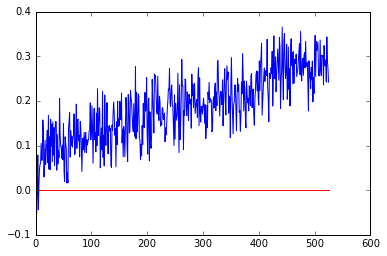

episode: 525 variance: 1


In [34]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
from engine import Engine
from pyglet.window import key
import util

import lstm

# train your model to (hopefully) walk by running this cell

# hit s to speed up training, and s again to watch the best set of weights
# use the up and down arrow keys to introduce more or less randomness in sampled torques

# this cell is an experiment with policy improvement
# the agent's joint torques (continuous, action) are randomly sampled from means output by a neural network
# the gradient which will shift the means given the state, is accumulated into a decaying single gradient
# if the agent experiences a large reward, we add the gradient to its weights, "reinforcing" the recent behavior
# in the case of a negative reward, we subtract the gradient, inhibiting recent behavior (hopefully!)

FILE = 'creatures/leggy2.json'

direction = 1

# Physics engine and window
LOWER_LIM = -.1 * np.pi
UPPER_LIM = .1 * np.pi
LIMIT = True
ANGLE_RANGE = UPPER_LIM - LOWER_LIM if LIMIT else np.pi*2.0

engine = Engine(caption='Train', ppm=15,width=1280, height=720, gravity=(0, -50), joint_limit=LIMIT, \
               upper_angle=UPPER_LIM, lower_angle=LOWER_LIM, max_torque=10000, \
                linear_damping=0.0, angular_damping=0.0)

# step floor
def add_steps(steps=8):
    offset = engine.width/steps
    for i in range(steps+1):
        engine.add_static_body((i * offset, 45), (10, 20))

# Load creature
engine.load(FILE)

# count joints and body parts
body_count = len(engine.bodies)
joint_count = len(engine.joints)

if body_count == 0 or joint_count == 0:
    engine.close()
    raise RuntimeError("Your model doesn't have any physics bodies or joints")
    
def reset_creature():
    engine.clear_all_but_ground()
    engine.load(FILE)
    
    engine.set_position((engine.width/2, engine.height/2))
    
    for j in engine.joints:
        j.motorSpeed = np.random.randn()
    
    engine.step_physics(50)
    for b in engine.bodies:
        b.linearVelocity = (0, 0)
        b.angularVelocity = 0

def features(time_step=0):
    f = []
    
    f += [direction]
    
    for j in engine.joints:
        a = j.angle
        r = (j.upperLimit - j.lowerLimit) if j.limitEnabled else np.pi*2.0
        a %= r
        a = a * 2.0 - 1.0
        #f += [a]
        #f += [np.tanh(j.speed)]
        
    for b in engine.bodies:
        a = b.angle % ANGLE_RANGE
        a /= ANGLE_RANGE
        a = a * 2.0 - 1.0
        f += [a]
        #f += [np.tanh(b.angularVelocity)]
        #f += [np.tanh(b.linearVelocity[0])]
        #f += [np.tanh(b.linearVelocity[1])]
        #f += [np.sin(a)]
        #f += [np.cos(a)]
        #f += [engine.to_window(b.position)[1]/engine.height]
        #f += [engine.to_window(b.position)[0]/engine.width]
        
        # collision
        if len(b.contacts) > 0:
            f += [1.0]
        else:
            f += [0.0]
    
    #f += [np.sin(time_step / 2.0)] # Creature's heartbeat? :-)
    #f += [np.cos(time_step / 2.0)]
    #f += [np.sin(time_step)]
    
    f += [1] # bias
    return np.array([f])



PHYS_STEPS = 20
variance = 1 # increase or decrease deviation from means output by nn

# model
TIMESTEPS = 128 # timesteps per episode

X_DIM = features(0).shape[1]
H_DIM = 32
Y_DIM = joint_count

model = lstm.LSTMNetwork(x_dim=X_DIM, h_dim=H_DIM, y_dim=Y_DIM,
                       time_steps=TIMESTEPS, 
                       act=lstm.tanh, 
                       act_p=lstm.tanh_p)

PAIRS = [] # pairs of good states and torques

def train(n=8):
    for i in range(n):
        idx = np.random.randint(0, len(PAIRS))

        S = PAIRS[idx][0]
        T = PAIRS[idx][1]
        R_trace = PAIRS[idx][2]
        
        S_Noise = []
        for x in S:
            S_Noise += [x + np.random.randn(x.shape[0], x.shape[1]) * 0.01]

        #h0 = np.zeros([1, H_DIM])
        #c0 = np.zeros([1, H_DIM])
        
        h0 = np.random.random_sample([1, H_DIM]) * .01
        c0 = np.random.random_sample([1, H_DIM]) * .01
    

        model.ff(S, h0, c0)

        dys = []
        for i in range(TIMESTEPS-1):
            h = model.outputs[i].h
            dy = h - T[i]
            dy *= R_trace[i]
            dys += [dy]

        model.bp(dys, learning_rate=0.001)

rs = []
total_r = 0.0
episode = 0

speedup = False
running = True
interacted = False

while running:
    if not interacted:
        rs += [total_r/TIMESTEPS]
    
    if episode % 25 == 0:
        clear_output(wait=True)
    
        if len(rs) > 1000:
            rs = rs[-1000:]
            
        fig = plt.plot(rs, 'b')
        plt.plot([0, len(rs)], [0, 0], 'r')
        plt.show()
        
        print('episode: {} variance: {}'.format(episode, np.round(variance, 2)))
    
    # new episode
    
    S = [] # keep list of states
    T = [] # keep list of torques
    R = [] # keep list of rewards
    
    # lstm state vectors
    h = np.zeros([1, H_DIM])
    c = np.zeros([1, H_DIM])
    
    #h = np.random.random_sample([1, H_DIM])
    #c = np.random.random_sample([1, H_DIM])
    
    total_r = 0.0
    t = 0
    episode += 1
    
    #direction = np.random.randint(0, 2)
    
    reset_creature()
    
    interacted = False
    reset = False
    while not reset:
        engine.window.dispatch_events()
        
        if engine.exited():
            running = False
            reset = True
                
        # keyboard input
        if engine.window.pressed(key.UP):
            variance += 0.1
        if engine.window.pressed(key.DOWN):
            variance -= 0.1
        if engine.window.pressed(key.S):
            speedup = not speedup
            
        if engine.window.pressed(key.RIGHT):
            direction += .1
        if engine.window.pressed(key.LEFT):
            direction -= .1
        direction = np.round(direction, 1)
            
        variance = max(variance, 0.0)
            
        engine.window.reset_keys()
        
        if engine.window.mouse_pressed:
            engine.create_mouse_joint()
            interacted = True
        else:
            engine.destroy_mouse_joint()
        
        engine.update_mouse_joint()
        
        dir_text = '{}'.format(direction)
        if direction == 1:
            dir_text = 'right'
        elif direction == -1:
            dir_text = 'left'
        elif direction == 0:
            dir_text = 'jump'
            
        text = 'episode: {} t: {} variance: {} direction: {}'.format(\
                episode, t, np.round(variance, 2), dir_text)
                
        x = features(t)
        
        # get model prediction
        model.ff([x], h, c)
        means = model.outputs[0].h[0]
        
        # keep track of state
        h = model.units[0].h.copy()
        c = model.units[0].c.copy()
        
        if variance > 0:
            torques = np.array([np.random.normal(loc=u, scale=np.sqrt(variance)) for u in means])
        else:
            torques = means
        
        start_p = engine.body_position()
                
        for i, j in enumerate(engine.joints):
            j.motorSpeed = torques[i]
        
        W = model.W
        matrices = [x.T, h.T, c.T, W['f'], W['i'], W['c'], W['o'], W['y']]
        
        for i in range(PHYS_STEPS):
            engine.step_physics(1)
            if not speedup:
                engine.window.clear()
                engine.window.draw_matrices(matrices, recalc=False)
                engine.window.draw_text(text)
                engine.render()
                engine.clock_tick()
                
        end_p = engine.body_position()
        
        reward = 0
        
        if direction == 1:
            reward = end_p[0] - start_p[0]
        elif direction == -1:
            reward = start_p[0] - end_p[0]
        elif direction == 0:
            reward = abs(start_p[1] - end_p[1]) - abs(start_p[0] - end_p[0])
        
        
        reward /= PHYS_STEPS
        total_r += reward
        
        
        # keep track of features, torques, and rewards
        S += [x]
        T += [torques]
        R += [reward]
        
        #if speedup and np.random.randint(0, 10) == 0:
        #    direction = np.random.randint(0, 3) - 1
        
        
        if end_p[0] > engine.width/2 + 400:
            engine.set_position((engine.width/2 - 350, end_p[1]), zero_vel=False)
        elif end_p[0] < engine.width/2 - 400:
            engine.set_position((engine.width/2 + 350, end_p[1]), zero_vel=False)
        
        if not speedup:
            engine.window.draw_matrices(matrices, recalc=True)
        
        if t >= TIMESTEPS - 1:
            reset = True
            
            # calculate trace
            r = 0
            R_trace = np.zeros([len(R)])
            idx = len(R)-1
            for rr in reversed(R):
                
                r += rr
                r *= 0.9
                R_trace[idx] = r
                idx -= 1
            
            #clear_output(wait=True)
            #plt.plot(R)
            #plt.plot(R_trace)
            #plt.plot([0, len(R)], [0, 0], c='r')
            #plt.show()
            
            # keep track
            PAIRS += [[S, T, R_trace]]
            if len(PAIRS) > 32:
                PAIRS = PAIRS[-32:]
            
            # train
            if len(PAIRS) > 0:
                train(n=4)
            
            
            if episode % 10 == 0:
                engine.window.clear()
                engine.window.draw_matrices(matrices, recalc=True)
                engine.window.draw_text(text)
                engine.render()
            
        t += 1

engine.close()

In [79]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, TimeDistributed

model = Sequential()
model.add(LSTM(10, return_sequences=True, input_dim=2))
model.add(TimeDistributed(Dense(4)))

model.compile(optimizer='rmsprop',loss='mse')

batchsize = 1
Ntime = 100
ins = np.random.random((batchsize, Ntime, 2))
outs = np.random.random((batchsize, Ntime, 4))
model.fit(x=ins,y=outs, batch_size=batchsize, nb_epoch=10)

Epoch 1/10
1/1 [==============================] - 1s - loss: 0.4511
Epoch 2/10
1/1 [==============================] - 0s - loss: 0.4234
Epoch 3/10
1/1 [==============================] - 0s - loss: 0.4045
Epoch 4/10
1/1 [==============================] - 0s - loss: 0.3892
Epoch 5/10
1/1 [==============================] - 0s - loss: 0.3759
Epoch 6/10
1/1 [==============================] - 0s - loss: 0.3639
Epoch 7/10
1/1 [==============================] - 0s - loss: 0.3529
Epoch 8/10
1/1 [==============================] - 0s - loss: 0.3426
Epoch 9/10
1/1 [==============================] - 0s - loss: 0.3328
Epoch 10/10
1/1 [==============================] - 0s - loss: 0.3234


In [80]:
# now you can give it a test sequence of any duration. Here, its 1000 timesteps.
model.predict(x=np.random.random((1,1000,2)))

array([[[ 0.10850468, -0.11950058, -0.05107182,  0.00274808],
        [ 0.15577987, -0.23360163, -0.09920343, -0.00549069],
        [ 0.11276637, -0.2698327 , -0.13510181,  0.02918982],
        ..., 
        [-0.00733893, -0.12297066,  0.03203527,  0.36381829],
        [ 0.01817065, -0.10814472,  0.01812418,  0.37500477],
        [ 0.03046877, -0.13876648,  0.02427833,  0.41089061]]], dtype=float32)

In [82]:
Out[80].shape

(1, 1000, 4)

In [4]:
a = [1, 2, 4]

In [5]:
a[-2:]

[2, 4]